In [ ]:
# ================================ LEGEND ================================
# Voigt order: [xx, yy, zz, yz, xz, xy] with engineering shear.
# ddot metric uses weights _WDOT = [1, 1, 1, 0.5, 0.5, 0.5].

# --- Material parameters ---
# E            : Young's modulus [stress]
# nu           : Poisson's ratio [-]
# sigy0        : initial yield stress [stress]
# Q, b         : Voce hardening: sig_y = sigy0 + Q*(1 - exp(-b*epbar)) [stress, 1]
# eta_vp       : Perzyna viscosity [stress·time]
# m_vp         : Perzyna exponent [-]

# --- Voigt algebra / elasticity helpers ---
# _WDOT        : weights for double-dot with engineering shear [(6,)]
# ddot6(a,b)   : double-dot in Voigt with _WDOT -> scalar
# lame_parameters(E,nu) -> (lam, mu) : Lamé parameters [stress]
# C_iso_6x6(E,nu) -> C               : isotropic stiffness (6x6) [stress]
# deviator_6(sig6) -> s              : deviatoric part (6,)
# von_mises(sig6) -> (seq, s)        : eq. stress [stress], deviator (6,)
# eq_strain_rate(epsdot6) -> eqdot   : VM equiv. total strain rate [1/time]

# --- Simulator ---
# simulate_3d(eps_hist, dt, E, nu) returns:
#   sig   : stress history (N,6) [stress]
#   ep    : plastic strain tensor history (N,6) [-]
#   epbar : accumulated plastic strain (N,) [-]
#   sig_y : current yield stress (N,) [stress]
#   f     : yield function f = seq - sig_y (N,) [stress]

# --- Strain histories (examples) ---
# make_uniaxial_xx / make_sine_*     : uniaxial xx paths (N,6)
# t                                  : time grid (N,) [time]
# dt                                 : time step [time]
# eps_tr, eps_va                     : train/validation total strain (N,6)

# --- Ground-truth responses (from simulator) ---
# sig_tr, ep_tr, epbar_tr, sigy_tr, f_tr   : training arrays
# sig_va, ep_va, epbar_va, sigy_va, f_va   : validation arrays

# --- Invariants for learning ---
# seq_tr, seq_va                 : equivalent stress from sig_* (N,) [stress]
# onset_idx                      : first index with epbar_tr > 0
# sigy0_hat                      : estimated initial yield [stress]
# over_tr, over_va               : overstress = max(seq - sigy0_hat, 0) [stress]
# epsdot_tr, epsdot_va           : total strain-rate (N,6) [1/time]
# eqepsdot_tr, eqepsdot_va       : equiv. total strain-rate (N,) [1/time]
# epbardot_tr, epbardot_va       : time derivative of epbar_* (N,) [1/time]
# mask_pl                        : boolean mask for plastic/active samples (N,)

# --- Feature construction and scaling ---
# names                          : base feature names ["over","epbar","eqeps_dot"]
# poly                           : PolynomialLibrary (degree, interactions)
# Phi_raw                        : design matrix Θ (n_plastic, n_terms)
# phi_names                      : names of polynomial terms
# Xmu, Xstd                      : mean and std of Θ across training plastic set
# ymu, ystd                      : mean and std of target y across training set
# Phi, y                         : z-scored Θ and target for SINDy

# --- SINDy sparse regression (SR3) ---
# lib                            : IdentityLibrary (Θ is precomputed)
# opt                            : SR3 optimizer (λ, ν, max_iter, tol)
# model                          : fitted SINDy model on (Phi, y)
# coefs_s                        : scaled coefficients (n_terms,)
# w_unscaled                     : coefficients mapped back to raw Θ units
# b_unscaled                     : intercept in raw units

# --- Learned RHS and rollout ---
# epbardot_fast(over, epbar, eqepsdot) -> g  : learned epbar_dot ≥ 0 [1/time]
# rollout_epbar(eps_hist, dt, E, nu) -> (sig, ep, epbar)
#   Integrates epbar via g, reconstructs ep = (3/2) g n dt, updates sig = C(eps-ep)

# --- Metrics ---
# vm_seq(sig_arr)                : helper to compute seq from a stress history
# seq_true, seq_pred             : true vs predicted equivalent stress (N,) [stress]
# rmse_sig                       : RMSE on stress tensor in Voigt metric [stress]
# rmse_seq                       : RMSE on equivalent stress [stress]
# rmse_ep                        : RMSE on plastic strain tensor [-]
# rmse_epb                       : RMSE on accumulated plastic strain [-]

# --- Plot variables ---
# t                              : time axis
# sig_va[:,0], sig_hat[:,0]      : true vs predicted σ_xx(t)
# epbar_va, epbar_hat            : true vs predicted epbar(t)
# seq_true, seq_pred             : true vs predicted σ_eq(t)
# =======================================================================


In [ ]:
%pip install pysindy
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import warnings
from pysindy.utils.axes import AxesWarning
warnings.filterwarnings("ignore", category=AxesWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 6.8 MB/s eta 0:00:00


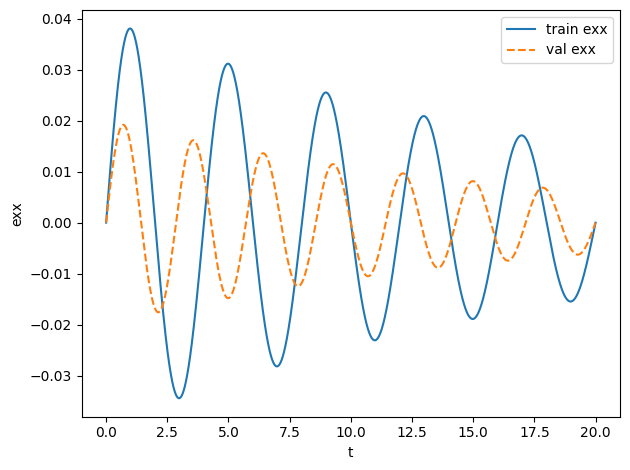

In [ ]:
# 3D Voce + Perzyna (small-strain J2) + SINDy on invariants
# ----------------------------------------------------------
# Voigt order: [xx, yy, zz, yz, xz, xy] with engineering shear.
# SINDy learns epbar_dot from scalar invariants: [overstress, epbar, eq_total_strain_rate].

import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

# ========= Material =========
E      = 2000.0          # Young's modulus
nu     = 0.30            # Poisson's ratio
sigy0  = 5.0             # initial yield stress
Q, b   = 12.0, 40.0      # Voce: sig_y = sigy0 + Q*(1 - exp(-b*epbar))
eta_vp = 20.0            # Perzyna viscosity
m_vp   = 1.0             # Perzyna exponent (1 = linear)

# ========= Voigt algebra helpers (engineering shear) =========
# Double-dot metric for engineering shear:
# a:b = a0*b0 + a1*b1 + a2*b2 + 0.5*(a3*b3 + a4*b4 + a5*b5)
_WDOT = np.array([1, 1, 1, 0.5, 0.5, 0.5], dtype=float)

def ddot6(a, b):
    """Double-dot product in 6x1 Voigt with engineering shear."""
    return float(np.sum(_WDOT * a * b))

def lame_parameters(E, nu):
    lam = E*nu/((1+nu)*(1-2*nu))
    mu  = E/(2*(1+nu))
    return lam, mu

def C_iso_6x6(E, nu):
    """Isotropic elasticity (6x6) for engineering shear."""
    lam, mu = lame_parameters(E, nu)
    C = np.zeros((6, 6), dtype=float)
    C[0:3, 0:3] = lam
    np.fill_diagonal(C[0:3, 0:3], lam + 2*mu)
    C[3, 3] = 2*mu; C[4, 4] = 2*mu; C[5, 5] = 2*mu
    return C

def deviator_6(sig6):
    """Deviatoric part of a 6-vector (subtract mean normal from normal comps)."""
    s = sig6.copy()
    p = np.mean(s[0:3])
    s[0:3] -= p
    return s

def von_mises(sig6):
    """Von Mises equivalent stress and deviator s, engineering shear metric."""
    s = deviator_6(sig6)
    seq = np.sqrt(1.5 * ddot6(s, s))
    return seq, s

def eq_strain_rate(epsdot6):
    """Von Mises equivalent total strain rate (uses deviatoric part)."""
    e = epsdot6.copy()
    e[0:3] -= np.mean(e[0:3])
    return np.sqrt(2.0/3.0 * ddot6(e, e))

# ========= Material model simulator
# Input strain, time step, stiffness and poisson ration =========
def simulate_3d(eps_hist, dt, E=E, nu=nu):
    """
    eps_hist: (N,6) total strain history in Voigt (engineering shear)
    dt:       time step
    Returns:  sig(N,6), ep(N,6), epbar(N,), sig_y(N,), f(N,)
    """
    N  = eps_hist.shape[0]
    C  = C_iso_6x6(E, nu)
    ep = np.zeros((N, 6))
    epbar = np.zeros(N)
    sig = np.zeros((N, 6))
    sig_y = np.zeros(N)
    f = np.zeros(N)

    tiny = 1e-16
    for k in range(1, N):
        # Elastic predictor from previous step state
        sig_tr = C @ (eps_hist[k-1] - ep[k-1])
        seq, s = von_mises(sig_tr)

        # Isotropic Voce hardening from accumulated plastic strain
        sigy_km1 = sigy0 + Q * (1.0 - np.exp(-b * epbar[k-1]))
        sig_y[k-1] = sigy_km1
        f[k-1] = seq - sigy_km1

        # Perzyna viscoplastic flow if overstress > 0
        if f[k-1] > 0.0 and seq > tiny:
            # For associative J2: epbar_dot equals the plastic multiplier lambda_dot
            epbar_dot = (f[k-1] / eta_vp) ** m_vp
            n = s / seq                                    # flow direction
            dep = 1.5 * epbar_dot * n                      # dep = (3/2) * epbar_dot * n
            ep[k]    = ep[k-1] + dt * dep
            epbar[k] = epbar[k-1] + dt * epbar_dot
        else:
            ep[k]    = ep[k-1]
            epbar[k] = epbar[k-1]

        # Stress update with corrected plastic strain at time k
        sig[k] = C @ (eps_hist[k] - ep[k])

    # Last-step bookkeeping
    seq_last, _ = von_mises(C @ (eps_hist[-1] - ep[-1]))
    sig_y[-1] = sigy0 + Q * (1.0 - np.exp(-b * epbar[-1]))
    f[-1] = seq_last - sig_y[-1]
    return sig, ep, epbar, sig_y, f

# ##################### UNIAXIAL LOAD #####################
# def make_uniaxial_xx(t, exx_max=0.006, rate=5e-4):
#   exx = np.minimum(rate * t, exx_max)
#   eps = np.zeros((len(t), 6))
#   eps[:, 0] = exx
#   return eps


# ##################### UNIAXIAL LOAD - sine type #####################
def make_sine_tc(t, A=0.004, f=0.25, a=0.05):
    exx = A * np.sin(2*np.pi*f*t) * np.exp(-a*t)
    eps = np.zeros((t.size, 6)); eps[:,0] = exx
    return eps

# Time grid
dt = 1e-3
t  = np.arange(0.0, 20.0, dt)

# Histories
# eps_tr = make_uniaxial_xx(t, exx_max=0.006, rate=5e-4)
# eps_va = make_uniaxial_xx(t, exx_max=0.004, rate=4e-4)
eps_tr = make_sine_tc(t, A=0.04, f=0.25, a=0.05)
eps_va = make_sine_tc(t, A=0.02, f=0.35, a=0.06)


# Ground-truth responses
sig_tr, ep_tr, epbar_tr, sigy_tr, f_tr = simulate_3d(eps_tr, dt)
sig_va, ep_va, epbar_va, sigy_va, f_va = simulate_3d(eps_va, dt)


# Base plot of the applied strain
plt.figure()
plt.plot(t, eps_tr[:, 0], label="train exx")
plt.plot(t, eps_va[:, 0], "--", label="val exx")
plt.xlabel("t"); plt.ylabel("exx")
plt.legend(); plt.tight_layout(); plt.show()

**seq** = von Mises equivalent stress. Encodes the J2 driving force (√(3/2)‖s‖).

**over** = seq − σ_y0_hat. Direct measure of overstress driving rate.

**epbar** = accumulated plastic strain. Captures hardening state.

**eqepsdot** = equivalent total strain-rate. Captures rate effects and activation due to loading speed.

**epbar_dot** (target) = scalar plastic multiplier you want to learn.

Plastic fraction (train): 0.885

=== Coefficients (scaled) ===
-6.334509e-01  *  over           
-9.907438e-01  *  epbar          
+7.744899e-01  *  eqeps_dot      
+1.261331e+00  *  over^2         
-0.000000e+00  *  over epbar     
+0.000000e+00  *  over eqeps_dot 
+1.123904e+00  *  epbar^2        
-0.000000e+00  *  epbar eqeps_dot
-0.000000e+00  *  eqeps_dot^2    

Intercept (unscaled): -6.228425e-03
Top terms (|coef|, unscaled):
+1.079321e+00  *  epbar^2
+9.072937e-01  *  eqeps_dot
-2.114392e-01  *  epbar
-2.138522e-03  *  over
+2.816339e-04  *  over^2


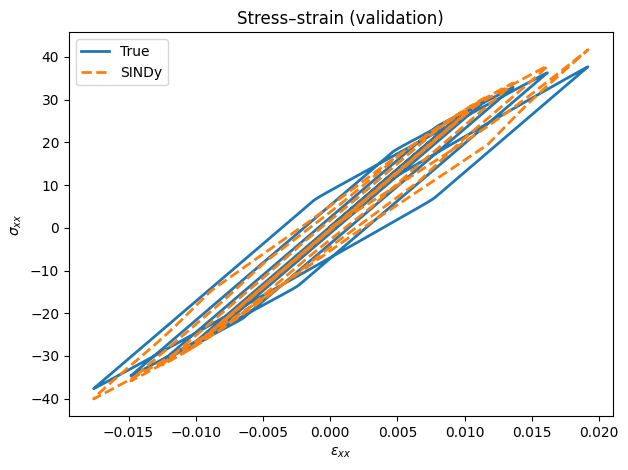


Validation RMSE  ||σ||: 6.2195e-01   seq: 1.8574e+00   ||ep||: 4.0427e-04   epbar: 5.0052e-03


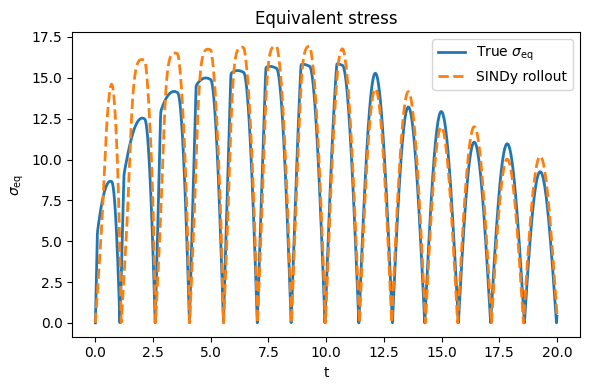

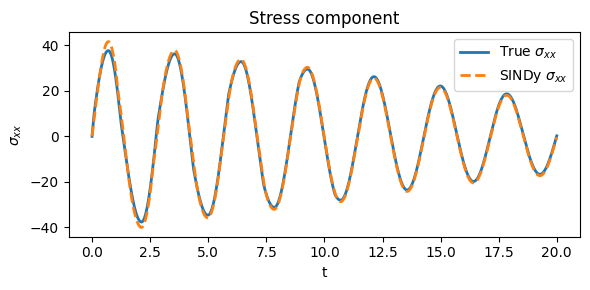

In [ ]:
# ========= Invariants for learning =========
# Equivalent stress
seq_tr = np.array([von_mises(sig_tr[k])[0] for k in range(len(t))])
seq_va = np.array([von_mises(sig_va[k])[0] for k in range(len(t))])

# Estimate initial yield from first plastic activation on TRAIN
onset_idx = np.argmax(epbar_tr > 0)
sigy0_hat = seq_tr[onset_idx] if onset_idx > 0 else sigy0

# Overstress (data-driven)
over_tr_raw = seq_tr - sigy0_hat
over_va_raw = seq_va - sigy0_hat
over_tr = np.maximum(over_tr_raw, 0.0)
over_va = np.maximum(over_va_raw, 0.0)


# Total strain-rate invariants
epsdot_tr = np.gradient(eps_tr, dt, axis=0)
epsdot_va = np.gradient(eps_va, dt, axis=0)
eqepsdot_tr = np.array([eq_strain_rate(epsdot_tr[k]) for k in range(len(t))])
eqepsdot_va = np.array([eq_strain_rate(epsdot_va[k]) for k in range(len(t))])

# Target: equivalent plastic strain rate
epbardot_tr = np.gradient(epbar_tr, dt)
epbardot_va = np.gradient(epbar_va, dt)

# Plastic-only mask: train on active plasticity and nonzero rate
mask_pl = (over_tr > 0.0) & (eqepsdot_tr > 1e-12)

print(f"Plastic fraction (train): {mask_pl.mean():.3f}")

#--------------------------------------
#######################################
############ L I B R A R Y ############
#######################################
#--------------------------------------

# ========= Design matrix Θ (polynomial features) =========
# Base features: X = [over, epbar, eqeps_dot]
X_tr = np.column_stack([over_tr, epbar_tr, eqepsdot_tr])[mask_pl]
y_tr = epbardot_tr[mask_pl]

names = ["over", "epbar", "eqeps_dot"]

# Degree-2 with interactions (expand if needed)
poly = ps.PolynomialLibrary(degree=2, include_bias=False, include_interaction=True)
Phi_raw  = poly.fit_transform(X_tr)
phi_names = poly.get_feature_names(input_features=names)

# Z-score Θ and y (fit on TRAIN-plastic)
Xmu  = Phi_raw.mean(0);  Xstd = Phi_raw.std(0) + 1e-12
ymu  = y_tr.mean();      ystd = y_tr.std()    + 1e-12
Phi  = (Phi_raw - Xmu)/Xstd
y    = (y_tr   - ymu)/ystd

##################   SINDY STARTS HERE   #############################
# ========= Sparse regression (SINDy) =========
######################################################################

lib = ps.IdentityLibrary()
opt = ps.SR3(reg_weight_lam=0.10, relax_coeff_nu=1.00, max_iter=10000, tol=1e-12)   #start playing with parameters to increase sparsity
model = ps.SINDy(feature_library=lib, optimizer=opt)
model.feature_names = phi_names
model.state_names   = ["epbar"]
model.fit(Phi, t=dt, x_dot=y)

# Coefficients (scaled and unscaled)
coefs_s = np.ravel(model.coefficients()[0])            # scaled weights
w_unscaled = (ystd / Xstd) * coefs_s                   # map back to raw features
b_unscaled = ymu - float(np.dot(w_unscaled, Xmu))      # intercept

# Report
w_len = max(12, max(len(n) for n in phi_names))
print("\n=== Coefficients (scaled) ===")
for c, n in zip(coefs_s, phi_names):
    print(f"{c:+12.6e}  *  {n:<{w_len}}")
print("\nIntercept (unscaled):", f"{b_unscaled:+.6e}")
print("Top terms (|coef|, unscaled):")
order = np.argsort(-np.abs(w_unscaled))
for j in order[:10]:
    if abs(w_unscaled[j]) > 0:
        print(f"{w_unscaled[j]:+.6e}  *  {phi_names[j]}")

# ========= Fast RHS (no model.predict) =========
def epbardot_fast(over, epbar, eqepsdot):
    #if over <= 0.0:            # enforce complementarity (just evaluating the plastic part)
    #    return 0.0
    Phi_row = poly.transform(np.array([[over, epbar, eqepsdot]]))[0]
    g = float(b_unscaled + np.dot(w_unscaled, Phi_row))
    return max(0.0, g)


###########################################
# ========= Rollout on validation =========
# ========= Prediction ====================
###########################################

def rollout_epbar(eps_hist, dt, E=E, nu=nu):
    """Integrate epbar via learned RHS and reconstruct tensorial ep by associative flow."""
    N = eps_hist.shape[0]
    C = C_iso_6x6(E, nu)
    sig = np.zeros((N, 6))
    ep  = np.zeros((N, 6))
    epbar = np.zeros(N)
    epsdot = np.gradient(eps_hist, dt, axis=0)
    tiny = 1e-16

    for k in range(1, N):
        # Elastic trial from previous state
        sig_tr = C @ (eps_hist[k-1] - ep[k-1])
        seq, s = von_mises(sig_tr)
        over   = max(seq - sigy0_hat, 0.0)
        eqdot  = eq_strain_rate(epsdot[k-1])

        # Learned equivalent plastic strain rate
        gk = epbardot_fast(over, epbar[k-1], eqdot)

        # Convert scalar rate to tensorial plastic flow: dep = (3/2)*gk*n
        if gk > 0.0 and seq > tiny:
            n = s / seq
            dep = 1.5 * gk * n
            ep[k]    = ep[k-1] + dt * dep
            epbar[k] = epbar[k-1] + dt * gk
        else:
            ep[k]    = ep[k-1]
            epbar[k] = epbar[k-1]

        # Stress update at k
        sig[k] = C @ (eps_hist[k] - ep[k])

    return sig, ep, epbar

## CALLING THE ROLLOUT (PREDICTION)
sig_hat, ep_hat, epbar_hat = rollout_epbar(eps_va, dt)

# ===== Uniaxial stress–strain (validation) =====
plt.figure()
plt.plot(eps_va[:, 0], sig_va[:, 0],  lw=2, label="True")
plt.plot(eps_va[:, 0], sig_hat[:, 0], "--", lw=2, label="SINDy")
plt.xlabel(r"$\varepsilon_{xx}$"); plt.ylabel(r"$\sigma_{xx}$")
plt.title("Stress–strain (validation)")
plt.legend(); plt.tight_layout(); plt.show()


# ========= Metrics =========
def vm_seq(sig_arr):
    return np.array([von_mises(s)[0] for s in sig_arr])

seq_true = vm_seq(sig_va)
seq_pred = vm_seq(sig_hat)

rmse_sig = np.sqrt(np.mean((sig_hat - sig_va)**2))                 # Frobenius in Voigt metric
rmse_seq = np.sqrt(np.mean((seq_pred - seq_true)**2))
rmse_ep  = np.sqrt(np.mean((ep_hat  - ep_va )**2))
rmse_epb = np.sqrt(np.mean((epbar_hat - epbar_va)**2))
print(f"\nValidation RMSE  ||σ||: {rmse_sig:.4e}   seq: {rmse_seq:.4e}   ||ep||: {rmse_ep:.4e}   epbar: {rmse_epb:.4e}")

# ========= Plot PART =========

plt.figure(figsize=(6,4))
plt.plot(t, seq_true,  lw=2, label=r"True $\sigma_{\rm eq}$")
plt.plot(t, seq_pred, "--", lw=2, label=r"SINDy rollout")
plt.xlabel("t"); plt.ylabel(r"$\sigma_{\rm eq}$"); plt.title("Equivalent stress"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(t, sig_va[:,0],  lw=2, label=r"True $\sigma_{xx}$")
plt.plot(t, sig_hat[:,0], "--", lw=2, label=r"SINDy $\sigma_{xx}$")
plt.xlabel("t"); plt.ylabel(r"$\sigma_{xx}$"); plt.title("Stress component"); plt.legend(); plt.tight_layout(); plt.show()






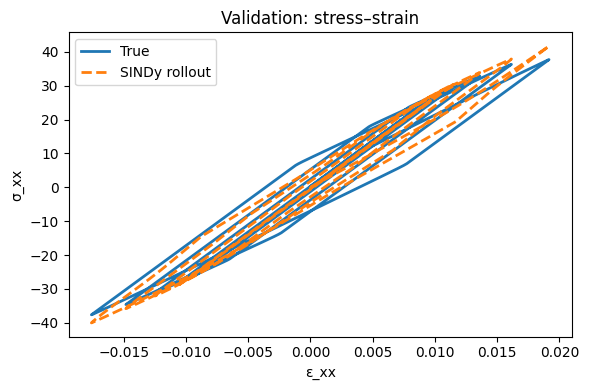

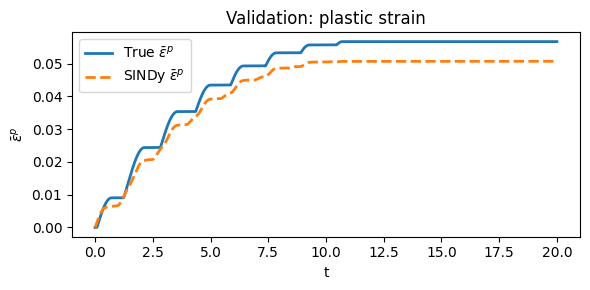

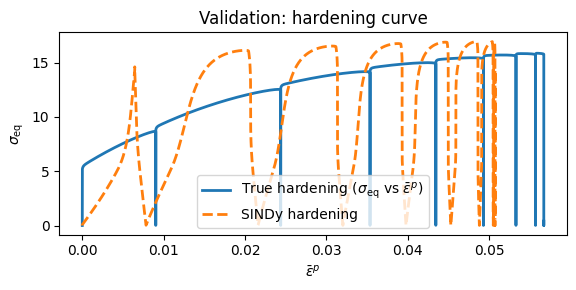

In [ ]:
#### SAME CHECK AS PREVIOUS CODE #####

# ================= SAME PLOTS, 3D VERSION =================
# Uniaxial stress–strain (use xx component)
plt.figure(figsize=(6,4))
plt.plot(eps_va[:,0], sig_va[:,0],  lw=2, label="True")
plt.plot(eps_va[:,0], sig_hat[:,0], "--", lw=2, label="SINDy rollout")
plt.xlabel("ε_xx"); plt.ylabel("σ_xx"); plt.title("Validation: stress–strain")
plt.legend(); plt.tight_layout(); plt.show()

# Plastic strain over time (use equivalent plastic strain epbar)
plt.figure(figsize=(6,3))
plt.plot(t, epbar_va,  lw=2, label=r"True $\bar\varepsilon^p$")
plt.plot(t, epbar_hat, "--", lw=2, label=r"SINDy $\bar\varepsilon^p$")
plt.xlabel("t"); plt.ylabel(r"$\bar\varepsilon^p$"); plt.title("Validation: plastic strain")
plt.legend(); plt.tight_layout(); plt.show()

# Hardening curve: σ_eq vs epbar
def vm_seq(sig_arr):
    return np.array([von_mises(s)[0] for s in sig_arr])

seq_true = vm_seq(sig_va)
seq_pred = vm_seq(sig_hat)

plt.figure(figsize=(6,3))
plt.plot(epbar_va,  seq_true,  lw=2, label=r"True hardening ($\sigma_{\rm eq}$ vs $\bar\varepsilon^p$)")
plt.plot(epbar_hat, seq_pred, "--", lw=2, label=r"SINDy hardening")
plt.xlabel(r"$\bar\varepsilon^p$"); plt.ylabel(r"$\sigma_{\rm eq}$"); plt.title("Validation: hardening curve")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
import matplotlib.pyplot as plt

Plastic fraction (train): 0.102

=== Coefficients (scaled) ===
+1.700815e+01  *  over_eq     
-2.005103e+01  *  epbar       
-0.000000e+00  *  eps_eq_dot  
+0.000000e+00  *  over_eq^2   
+2.619157e+00  *  epbar^2     
+0.000000e+00  *  eps_eq_dot^2

Intercept (unscaled): +1.804669e-03
Top terms (|coef|, unscaled):
+4.265340e+02  *  epbar^2
-2.531347e+01  *  epbar
+5.321886e-02  *  over_eq

Validation RMSE  σ_eq: 2.2051e-03   epbar: 9.5556e-07


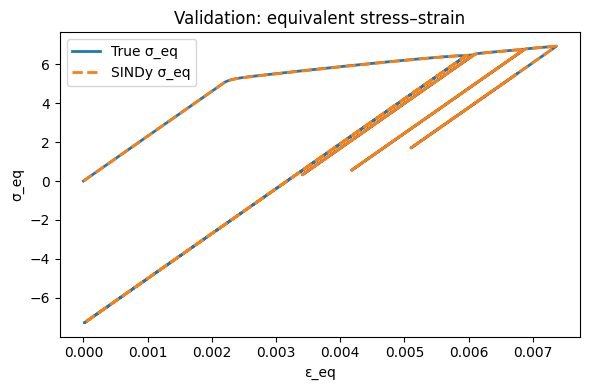

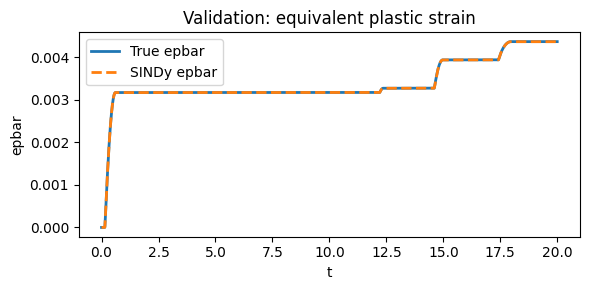

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import warnings
from pysindy.utils.axes import AxesWarning
warnings.filterwarnings("ignore", category=AxesWarning)

# -----------------------------
# Helpers: dev/eq measures for 3D -> scalar reduction
# -----------------------------
I3 = np.eye(3)

def dev(A):
    """Deviatoric part of a 3x3 tensor."""
    return A - np.trace(A)/3.0 * I3

def eps_eq_from_tensor_series(eps_series):
    """
    Convert a time series of total small-strain tensors (N,3,3)
    to the von Mises equivalent total strain scalar series (N,).
    Use tensorial shear (NOT engineering shear).
    eps_eq = sqrt(2/3) * ||dev(eps)||
    """
    eq = np.zeros(len(eps_series))
    for k, E in enumerate(eps_series):
        ed = dev(E)
        eq[k] = np.sqrt(2.0/3.0) * np.linalg.norm(ed)
    return eq

# -----------------------------
# True material (Voce + Perzyna) in "equivalent" 1D form
# IMPORTANT: E will be set to 3G, not the original Young's modulus.
# -----------------------------
E_3D  = 2000.0       # Young's modulus you would use in 3D
nu    = 0.30         # Poisson's ratio
G     = E_3D / (2*(1+nu))
E     = 3.0 * G      # <-- EFFECTIVE modulus for von Mises equivalent relation

sigy0 = 5.0
Q, b  = 12.0, 40.0             # Voce: sig_y = sigy0 + Q(1 - exp(-b*epbar))
eta_vp = 20.0                  # Perzyna viscosity

def simulate(eps, dt):
    """
    IDENTICAL interface to the original 1D simulate, but now:
    - 'eps' means von Mises equivalent total strain (scalar)
    - 'ep'  means equivalent plastic strain epbar (scalar)
    - 'sig' means von Mises equivalent stress sigma_eq (scalar)
    - Elastic relation is enforced by E = 3G (already set globally)
    """
    ep = np.zeros_like(eps); sig = np.zeros_like(eps)
    sig_y = np.zeros_like(eps); f = np.zeros_like(eps)
    for k in range(1, len(eps)):
        # Elastic predictor in equivalent space: sigma_eq = 3G * (eps_eq - epbar)
        sig[k-1]   = E*(eps[k-1] - ep[k-1])
        # Voce hardening on epbar
        sig_y[k-1] = sigy0 + Q*(1.0 - np.exp(-b*ep[k-1]))
        # Overstress in equivalent form
        f[k-1]     = sig[k-1] - sig_y[k-1]
        # Perzyna (m=1): gamma_dot = <f>/eta
        ep_dot     = max(0.0, f[k-1]) / eta_vp
        # Explicit Euler
        ep[k]      = ep[k-1] + dt * ep_dot
    # last step
    sig[-1]   = E*(eps[-1] - ep[-1])
    sig_y[-1] = sigy0 + Q*(1.0 - np.exp(-b*ep[-1]))
    f[-1]     = sig[-1] - sig_y[-1]
    return sig, ep, sig_y, f

# -----------------------------
# Build a 3D strain path, then REDUCE to equivalent scalar series
# You can replace 'make_path_3d' with your own multi-axial history.
# -----------------------------
dt = 1e-3
t  = np.arange(0, 20, dt)

def make_path_3d(t):
    """
    Example multiaxial path:
    exx(t) = Ax*sin(...) * exp(-a t) + r t   (axial)
    gxy(t) = Ash*sin(...) * exp(-a t)        (engineering shear)
    Store tensorial shear eps_xy = gxy/2
    """
    Ax, fx, ax, r  = 0.006, 0.50, 0.10, 0.0005

    Ash,fsh,ash    = 0.004, 0.35, 0.08
    exx = Ax*np.sin(2*np.pi*fx*t) + r*t
    gxy = Ash*np.sin(2*np.pi*fsh*t)
    #gxy = 0.0
    eps = np.zeros((len(t),3,3))
    eps[:,0,0] = exx
    eps[:,0,1] = eps[:,1,0] = 0.5 * gxy  # tensorial shear
    return eps

def make_path_3d_val(t):
    Ax, fx, ax, r  = 0.003, 0.35, 0.02, 0.0005
    Ash,fsh,ash    = 0.010, 0.42, 0.06
    exx = Ax*np.sin(2*np.pi*fx*t)*np.exp(-ax*t) + r*t
    gxy = Ash*np.sin(2*np.pi*fsh*t)*np.exp(-ash*t)
    eps = np.zeros((len(t),3,3))
    eps[:,0,0] = exx
    eps[:,0,1] = eps[:,1,0] = 0.5 * gxy
    return eps

eps3D_tr = make_path_3d(t)
eps3D_va = make_path_3d_val(t)

# Collapse 3D -> scalar equivalent total strain histories
eps_tr = eps_eq_from_tensor_series(eps3D_tr)  # <-- use this as "eps" in 1D code
eps_va = eps_eq_from_tensor_series(eps3D_va)

# -----------------------------
# Generate 'true' data in equivalent space (same pipeline as your 1D code)
# -----------------------------
sig_tr, ep_tr, sigy_tr, f_tr = simulate(eps_tr, dt)  # sig==sigma_eq, ep==epbar
sig_va, ep_va, sigy_va, f_va = simulate(eps_va, dt)

# Time derivatives
epsdot_tr = np.gradient(eps_tr, dt); epdot_tr = np.gradient(ep_tr, dt)   # epsdot_eq, epbar_dot
epsdot_va = np.gradient(eps_va, dt); epdot_va = np.gradient(ep_va, dt)

# -----------------------------
# Overstress features: X = [over_eq, epbar, eps_eq_dot]
# (Names kept as in your code for minimal change, but interpret accordingly.)
# -----------------------------
sigy0_hat = sig_tr[np.argmax(ep_tr > 0)]        # first plastic point estimate
over_tr   = sig_tr - sigy0_hat                  # equivalent overstress with fixed sigy0_hat
over_va   = sig_va - sigy0_hat

tol = 1e-10
mask_pl = epdot_tr > tol
print(f"Plastic fraction (train): {mask_pl.mean():.3f}")

X_raw = np.column_stack([over_tr, ep_tr, epsdot_tr])[mask_pl]
y_raw = epdot_tr[mask_pl]  # target: epbar_dot

# -----------------------------
# Θ via PolynomialLibrary on [over_eq, epbar, eps_eq_dot]
# -----------------------------
names = ["over_eq","epbar","eps_eq_dot"]
poly = ps.PolynomialLibrary(degree=2, include_bias=False, include_interaction=False)
Phi_raw  = poly.fit_transform(X_raw)
phi_names= poly.get_feature_names(input_features=names)

# -----------------------------
# Z-score Θ and y (fit on TRAIN-plastic)
# -----------------------------
Xmu  = Phi_raw.mean(0);  Xstd = Phi_raw.std(0) + 1e-12
ymu  = y_raw.mean();     ystd = y_raw.std()    + 1e-12

Phi = (Phi_raw - Xmu)/Xstd
y   = (y_raw  - ymu)/ystd

# -----------------------------
# Fit (SR3), same as your code
# -----------------------------
lib = ps.IdentityLibrary()
opt = ps.SR3(reg_weight_lam=0.1, relax_coeff_nu=1, max_iter=10000, tol=1e-12)
model = ps.SINDy(feature_library=lib, optimizer=opt)
model.feature_names = phi_names
model.state_names   = ["epbar"]
model.fit(Phi, t=dt, x_dot=y)

# -----------------------------
# Coefficients (scaled & unscaled) + print
# -----------------------------
coefs_s = np.ravel(model.coefficients()[0])
w_unscaled = (ystd / Xstd) * coefs_s
b_unscaled = ymu - np.dot(w_unscaled, Xmu)

w_len = max(12, max(len(n) for n in phi_names))
print("\n=== Coefficients (scaled) ===")
for c, n in zip(coefs_s, phi_names):
    print(f"{c:+12.6e}  *  {n:<{w_len}}")
print("\nIntercept (unscaled):", f"{b_unscaled:+.6e}")
print("Top terms (|coef|, unscaled):")
order = np.argsort(-np.abs(w_unscaled))
for j in order[:8]:
    if abs(w_unscaled[j]) > 0:
        print(f"{w_unscaled[j]:+.6e}  *  {phi_names[j]}")

# -----------------------------
# FAST RHS in equivalent space (no model.predict)
# -----------------------------
def epbardot_fast(over_eq, epbar, eps_eq_dot):
    Phi_row = poly.transform(np.array([[over_eq, epbar, eps_eq_dot]]) )[0]
    g = float(b_unscaled + np.dot(w_unscaled, Phi_row))
    return max(0.0, g)  # physical cutoff

# -----------------------------
# Rollout on VALIDATION in equivalent space
# -----------------------------
ep_hat = np.zeros_like(ep_va)  # epbar_hat
for k in range(1, len(t)):
    sig_k  = E*(eps_va[k-1] - ep_hat[k-1])   # sigma_eq
    over_k = sig_k - sigy0_hat               # over_eq (fixed sigy0_hat)
    gk     = epbardot_fast(over_k, ep_hat[k-1], epsdot_va[k-1])
    ep_hat[k] = ep_hat[k-1] + dt*gk
sig_hat = E*(eps_va - ep_hat)                # sigma_eq_hat

rmse_sig = np.sqrt(np.mean((sig_hat - sig_va)**2))
rmse_ep  = np.sqrt(np.mean((ep_hat  - ep_va )**2))
print(f"\nValidation RMSE  σ_eq: {rmse_sig:.4e}   epbar: {rmse_ep:.4e}")

# -----------------------------
# Plots in equivalent space
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(eps_va, sig_va,  lw=2, label="True σ_eq")
plt.plot(eps_va, sig_hat, "--", lw=2, label="SINDy σ_eq")
plt.xlabel("ε_eq"); plt.ylabel("σ_eq"); plt.title("Validation: equivalent stress–strain")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(t, ep_va,  lw=2, label="True epbar")
plt.plot(t, ep_hat, "--", lw=2, label="SINDy epbar")
plt.xlabel("t"); plt.ylabel("epbar"); plt.title("Validation: equivalent plastic strain")
plt.legend(); plt.tight_layout(); plt.show()